In [1]:
import itertools
import sys, os

from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from sklearn.metrics import classification_report, accuracy_score
#import sklearn.metrics as metrics
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import auc

from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy import stats

In [ ]:
pd.set_option('max_colwidth', 100)

In [2]:
os.listdir('results')

['mit9313_SRR3334787_counts.csv.gz', 'mit9313_SRR3334787_cover.csv.gz']

In [3]:
count_df = pd.read_csv(os.path.join('results', 'mit9313_SRR3334787_counts.csv.gz'))

In [10]:
count_df.columns

Index(['Unnamed: 0', 'contig_id', 'gene_id', 'feature_id', 'type', 'location',
       'start', 'stop', 'strand', 'function', 'aliases', 'figfam',
       'evidence_codes', 'nucleotide_sequence', 'aa_sequence', 'min_idx',
       'max_idx', 'inter_stop_idx', 'inter_length', 'gene_length',
       'gene_is_reversed', 'reads', 'as_reads', 'reads_inter',
       'as_reads_inter', 'clip_reads'],
      dtype='object')

In [11]:
max_count_clip = 8000
count_df['clip_reads'] = count_df['reads'].clip(upper=max_count_clip)
count_df['clip_as_reads'] = count_df['as_reads'].clip(upper=max_count_clip)
count_df['clip_reads_inter'] = count_df['reads_inter'].clip(upper=max_count_clip)
count_df['clip_as_reads_inter'] = count_df['as_reads_inter'].clip(upper=max_count_clip)

In [12]:
count_df.head()

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,gene_length,gene_is_reversed,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter
0,0,MIT9313,PMIT9313_0001,fig|1218.91.peg.1,peg,MIT9313_174_1340,174,1340,+,DNA polymerase III beta subunit (EC 2.7.7.7),...,1166,False,792,1949,0,0,792,1949,0,0
1,1,MIT9313,PMIT9313_0002,fig|1218.91.peg.2,peg,MIT9313_1368_2120,1368,2120,+,RNA metabolism-related protein,...,752,False,70,508,0,0,70,508,0,0
2,2,MIT9313,PMIT9313_0003,fig|1218.91.peg.3,peg,MIT9313_2160_4562,2160,4562,+,"Phosphoribosylformylglycinamidine synthase, sy...",...,2402,False,492,1396,4,4,492,1396,4,4
3,3,MIT9313,PMIT9313_0004,fig|1218.91.peg.4,peg,MIT9313_4622_6079,4622,6079,+,Amidophosphoribosyltransferase (EC 2.4.2.14),...,1457,False,198,748,0,0,198,748,0,0
4,4,MIT9313,PMIT9313_0005,fig|1218.91.peg.5,peg,MIT9313_8604_6115,8604,6115,-,DNA gyrase subunit A (EC 5.99.1.3),...,2489,True,728,1733,8,2,728,1733,8,2


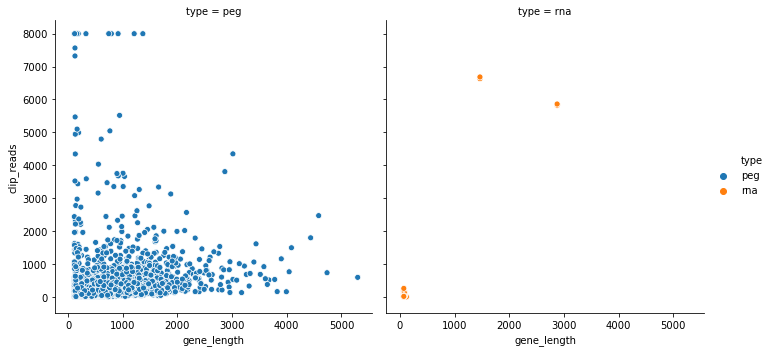

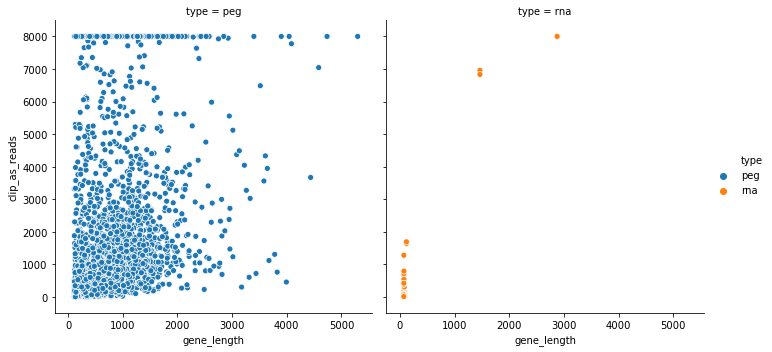

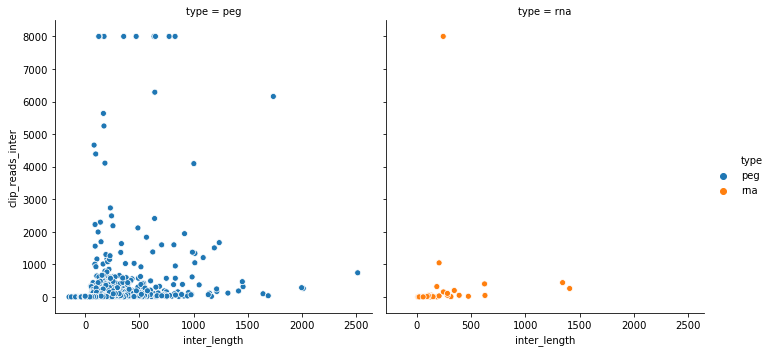

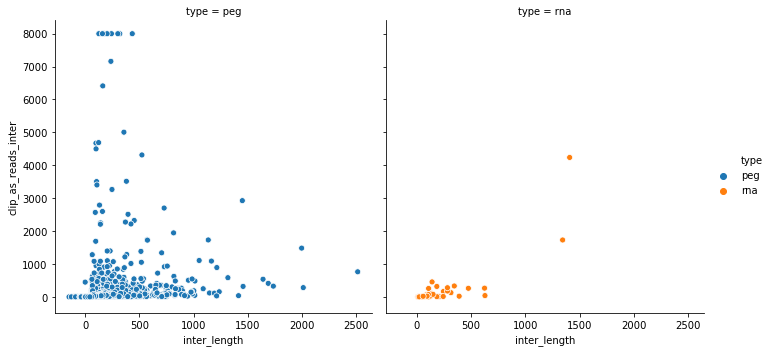

In [18]:
g = sns.relplot(data=count_df, x='gene_length', y='clip_reads', col='type', hue='type')
g = sns.relplot(data=count_df, x='gene_length', y='clip_as_reads', col='type', hue='type')
g = sns.relplot(data=count_df, x='inter_length', y='clip_reads_inter', col='type', hue='type')
g = sns.relplot(data=count_df, x='inter_length', y='clip_as_reads_inter', col='type', hue='type')

#g.set(yscale='log')

In [29]:
count_df.groupby('type')[['inter_length', 'gene_length']].describe().T

type                        peg          rna
inter_length count  2993.000000    51.000000
             mean    116.920815   189.235294
             std     193.301334   282.470359
             min    -149.000000     8.000000
             25%       8.000000    35.000000
             50%      56.000000   107.000000
             75%     148.000000   204.000000
             max    2513.000000  1408.000000
gene_length  count  2993.000000    51.000000
             mean    681.122619   240.549020
             std     618.720384   602.610697
             min     113.000000    70.000000
             25%     188.000000    71.000000
             50%     497.000000    73.000000
             75%     995.000000    81.000000
             max    5297.000000  2876.000000

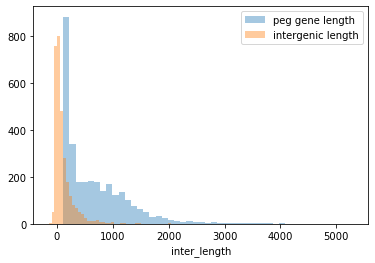

In [30]:
sns.distplot(count_df.loc[count_df.type == 'peg','gene_length'], kde=False, label='peg gene length')
#sns.distplot(count_df.loc[count_df.type == 'rna','gene_length'], kde=False, label='rna gene length')

sns.distplot(count_df.inter_length, kde=False, label='intergenic length')
plt.legend()

In [31]:
113/3

37.666666666666664

In [33]:
300/3

100.0

In [37]:
count_df.loc[count_df.clip_reads == max_count_clip]

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,gene_length,gene_is_reversed,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter
884,884,MIT9313,PMIT9313_0871,fig|1218.91.peg.871,peg,MIT9313_742764_743972,742764,743972,+,NAD binding site,...,1208,False,11163,557,0,0,8000,557,0,0
973,973,MIT9313,PMIT9313_0958,fig|1218.91.peg.958,peg,MIT9313_832281_833648,832281,833648,+,Chloride channel protein-related protein,...,1367,False,21104,991,199,21,8000,991,199,21
1361,1361,MIT9313,PMIT9313_1343,fig|1218.91.peg.1343,peg,MIT9313_1082336_1082151,1082336,1082151,-,hypothetical protein,...,185,True,16687,13,0,4672,8000,13,0,4672
1620,1620,MIT9313,PMIT9313_1600,fig|1218.91.peg.1600,peg,MIT9313_1272346_1272188,1272346,1272188,-,FIG00944368: hypothetical protein,...,158,True,16586,18,0,161,8000,18,0,161
1937,1937,MIT9313,PMIT9313_1912,fig|1218.91.peg.1912,peg,MIT9313_1515447_1515334,1515447,1515334,-,FIG00943729: hypothetical protein,...,113,True,8305,7,0,0,8000,7,0,0
2386,2386,MIT9313,PMIT9313_2350,fig|1218.91.peg.2350,peg,MIT9313_1841362_1841243,1841362,1841243,-,FIG00942270: hypothetical protein,...,119,True,9125,3,0,0,8000,3,0,0
2448,2448,MIT9313,PMIT9313_2410,fig|1218.91.peg.2410,peg,MIT9313_1897320_1898111,1897320,1898111,+,Protein involved in meta-pathway of phenol degradation,...,791,False,8924,324,1636,32,8000,324,1636,32
2532,2532,MIT9313,PMIT9313_2491,fig|1218.91.peg.2491,peg,MIT9313_1971557_1970814,1971557,1970814,-,Glycosyl transferase WecB/TagA/CpsF,...,743,True,20840,316,157,143,8000,316,157,143
2568,2568,MIT9313,PMIT9313_2526,fig|1218.91.peg.2526,peg,MIT9313_2001586_2000672,2001586,2000672,-,5'-methylthioadenosine phosphorylase (EC 2.4.2.28),...,914,True,11091,933,19,9,8000,933,19,9
2632,2632,MIT9313,PMIT9313_2589,fig|1218.91.peg.2589,peg,MIT9313_2059734_2059408,2059734,2059408,-,FIG00943694: hypothetical protein,...,326,True,295340,301,27,226742,8000,301,27,8000


In [38]:
count_df.loc[count_df.clip_as_reads == max_count_clip]

,Unnamed: 0,contig_id,gene_id,feature_id,type,location,start,stop,strand,function,...,gene_length,gene_is_reversed,reads,as_reads,reads_inter,as_reads_inter,clip_reads,clip_as_reads,clip_reads_inter,clip_as_reads_inter
28,28,MIT9313,PMIT9313_0029,fig|1218.91.peg.29,peg,MIT9313_30851_31915,30851,31915,+,NADPH-dependent glyceraldehyde-3-phosphate dehydrogenase (EC 1.2.1.13),...,1064,False,434,8729,2,15,434,8000,2,15
54,54,MIT9313,PMIT9313_0054,fig|1218.91.peg.54,peg,MIT9313_52126_50930,52126,50930,-,Sulfolipid (UDP-sulfoquinovose) biosynthesis protein,...,1196,True,229,11343,22,2,229,8000,22,2
70,70,MIT9313,PMIT9313_0070,fig|1218.91.peg.70,peg,MIT9313_62968_61610,62968,61610,-,ATP-dependent Clp protease ATP-binding subunit ClpX,...,1358,True,336,8921,141,24,336,8000,141,24
72,72,MIT9313,PMIT9313_0072,fig|1218.91.peg.72,peg,MIT9313_65217_63778,65217,63778,-,Cell division trigger factor (EC 5.2.1.8),...,1439,True,409,9962,5,20,409,8000,5,20
76,76,MIT9313,PMIT9313_0076,fig|1218.91.peg.76,peg,MIT9313_67501_69432,67501,69432,+,"Zn-dependent hydrolase, RNA-metabolising",...,1931,False,503,11542,0,0,503,8000,0,0
92,92,MIT9313,PMIT9313_0092,fig|1218.91.peg.92,peg,MIT9313_87244_87741,87244,87741,+,"6,7-dimethyl-8-ribityllumazine synthase (EC 2.5.1.78)",...,497,False,144,12878,19,45,144,8000,19,45
95,95,MIT9313,PMIT9313_0094,fig|1218.91.peg.94,peg,MIT9313_88626_91472,88626,91472,+,Protein export cytoplasm protein SecA ATPase RNA helicase (TC 3.A.5.1.1),...,2846,False,823,9181,75,117,823,8000,75,117
102,102,MIT9313,PMIT9313_0101,fig|1218.91.peg.101,peg,MIT9313_99535_101931,99535,101931,+,PROBABLE HEMAGGLUTININ-RELATED PROTEIN,...,2396,False,158,18950,0,0,158,8000,0,0
155,155,MIT9313,PMIT9313_0154,fig|1218.91.peg.154,peg,MIT9313_157203_158624,157203,158624,+,Adenosylhomocysteinase (EC 3.3.1.1),...,1421,False,650,15398,0,0,650,8000,0,0
203,203,MIT9313,PMIT9313_0202,fig|1218.91.peg.202,peg,MIT9313_202344_201982,202344,201982,-,Photosystem II 12 kDa extrinsic protein (PsbU),...,362,True,102,47611,121,11,102,8000,121,11


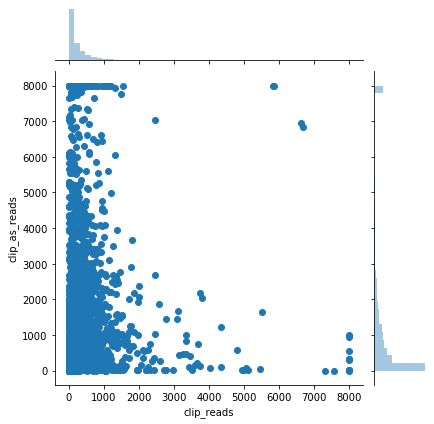

In [40]:
sns.jointplot(count_df.clip_reads, count_df.clip_as_reads)

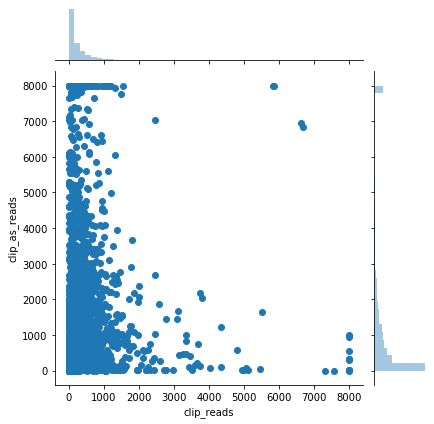

In [40]:
sns.jointplot(count_df.clip_reads, count_df.clip_as_reads)